In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, KFold

import pickle, json
import scipy.io
from bci_funcs import windowed_mean, base_correct, select_mean, slope

path = '/Users/lukasgehrke/Documents/publications/2022-CHI-neuroadaptive-haptics/' # add path to repository here!!!

# Preconscious Augmentation

This script trains the classifier for a brain-computer interface that controls electrical muscle stimulation in the preconscious augmentation experiment.
The functions used to build the feature vectors are the same that are used for the online application and are found in 'bci_funcs'

A two class linear discriminant model is fitted to idle and pre-movement EEG training data. The model and a channel selection is saved.

## Comment for Marius 16.05.2023

So i tried different features here, the feature computation functions are in bci_funcs.py and used both here in this script and in instances of real-time application from the class Classifier in Classifier.py.
Don't mind where the selected channel indices are coming from for now, that happens elsewhere in matlab but is irrelevant for the moment.

The problem with windowed means is that the feature vector gets very high dimensional, so e.g. with 10 channels and 10 windows = 100. However, we only have about 90 training trials so the LDA would be highly over-determined. Many studies do use such overdetermined classifiers, for example (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7986527/pdf/ENEURO.0425-20.2020.pdf). I have encountered though that while this works in cross-validation on the training data/epoch, it works quite badly when applied to experiment data that is some minutes later than the training data. What I have seen are frequent changes between classes and huge jumps in probability for the predicted class, even with only a small change in the samples. So for example if i change 25 sample of a 250 sample epoch that changes the prediction quite dramatically. So that is why I reduced the feature space to 1 feature for 10 channels, hence 90 training trials and 10 features. See this here for more information about what i encountered empirically (https://stats.stackexchange.com/questions/51490/how-large-a-training-set-is-needed). You may be already quite familiar with that. Keep in mind that these are not yet the features for neuroadaptive haptics but for another project using readiness potential (which is why I came up with slope as feature). Question is have you enctountered this before and how do you adress this? Is this generally solved by using shrinkage/regularization?

In [ ]:
pre_move = scipy.io.loadmat(path+os.sep+'example_data'+os.sep+'pre_move_Baseline.mat')
idle = scipy.io.loadmat(path+os.sep+'example_data'+os.sep+'idle_Baseline.mat')
chans = np.array(pd.read_csv(path+os.sep+'example_data'+os.sep+'sel_chans.csv', header=None)).flatten()
chans = chans - 1 # Matlab to python indexing

chans = chans[0:15]
chans = chans.tolist() # first three channels are C3, C4, Cz, in that order. Might ignore, then start index at 3

data_srate = 250
windows = 10
sel_window = 10
baseline = data_srate/windows

idle = idle['idle'][chans,:,:]
pre_move = pre_move['pre_move'][chans,:,:]

idle_means = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
pre_move_means = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

idle_mean = np.zeros((idle.shape[2], idle.shape[0]))
pre_move_mean = np.zeros((pre_move.shape[2], pre_move.shape[0]))

slope_idle = np.zeros((idle.shape[2], idle.shape[0]))
slope_pre_move = np.zeros((pre_move.shape[2], pre_move.shape[0]))

target_class = 1
threshold = 1
classifier_update_rate = 10 # samples

bci_params = dict(((k, eval(k)) for k in ('chans', 'windows', 'baseline', 'target_class', 'threshold', 'data_srate', 'classifier_update_rate')))
with open(path+os.sep+'example_data'+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)

for trial_ix in range(0, pre_move.shape[2]):
    tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
    pre_move_means[trial_ix, :] = windowed_mean(tmp, windows).flatten()
    pre_move_mean[trial_ix, :] = select_mean(tmp, windows, sel_window).flatten()
    slope_pre_move[trial_ix, :] = slope(tmp, 'linear').flatten()

for trial_ix in range(0, idle.shape[2]):
    tmp = base_correct(idle[:,:,trial_ix], baseline-1)
    idle_means[trial_ix, :] = windowed_mean(tmp, windows).flatten()
    idle_mean[trial_ix, :] = select_mean(tmp, windows, sel_window).flatten()
    slope_idle[trial_ix, :] = slope(tmp, 'linear').flatten()

win_means = np.concatenate((pre_move_means, idle_means), axis = 0)
win_mean = np.concatenate((pre_move_mean, idle_mean), axis = 0)
slope = np.concatenate((slope_pre_move, slope_idle), axis = 0)

In [3]:
pre_move_class = np.ones((pre_move_means.shape[0], 1))
idle_class = np.zeros((idle_means.shape[0], 1))
classes = np.concatenate((pre_move_class, idle_class)).ravel()

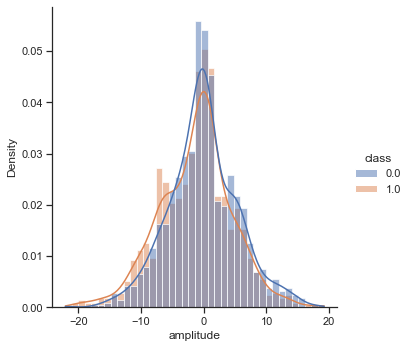

In [4]:
data = slope

data_to_plot = pd.DataFrame(data)
data_to_plot['class'] = classes
data_to_plot = data_to_plot.melt(id_vars = 'class', value_name = 'amplitude')

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
sns.displot(x="amplitude", hue="class", data=data_to_plot, kde=True, fill=True, stat="density")


# Crossvalidation and saving the model for real-time use

In [5]:
clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)

kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
print(cv_results.mean())
print(cv_results.std())

filename = path+os.sep+'example_data'+os.sep+'model_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

0.75
0.05050762722761051
